In [1]:
import pandas as pd
# import wget

In [24]:
# url = "https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR"

# wget.download(url, 'C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/articles.csv')

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

**ПОЗАВТРАКАЛИ**

Стемминг (убираем лишнии куски слова):
**завтрак**<br>
Очень быстро, очень дешево и очень слабо.

Лемматизация (перевод в неопределенную форму для гл. и в им.падеж для сущ.):
**завтракать**<br>
Небыстро, сложно.

In [5]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

Не все слова равны, не все слова одинаково работают. К примеру, союзы и предлоги в нашей задаче никак не помогут, поэтому можем их выкидывать. (Но в задачах оценки стиля, к примеру, такие слова будут очень полезны).

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Вадим\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [8]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [9]:
with open('stopwords.txt', encoding="utf8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
stopword_ru[200:210]

['ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам']

In [11]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [12]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|                                                                                        | 0/27000 [00:00<?, ?it/s]C:\Users\Вадим\AppData\Local\Temp\ipykernel_5940\4083466619.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:46<00:00, 579.95it/s]

CPU times: total: 46.6 s
Wall time: 46.7 s


In [13]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [14]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [06:14<00:00, 72.19it/s]

CPU times: total: 6min 14s
Wall time: 6min 14s


А теперь в 3 строчки обучим нашу модель

In [15]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [26]:
N_topic = 20

In [27]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: total: 2min 5s
Wall time: 1min 3s


In [28]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/Lda_median/model.lda")
lda.save(temp_file)

In [29]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [30]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.13848947), (6, 0.33911783), (13, 0.39169055), (18, 0.10901319)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [31]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: ребёнок погибнуть область население семья авария конкурс
topic_1: выяснить тело рак турция поверхность турецкий кровь
topic_2: китай пациент китайский вода офицер высота подчёркивать
topic_3: градус девочка употребление температура грунт билет курение
topic_4: украина россия санкция рф документ украинский российский
topic_5: сша военный американский армия операция система запуск
topic_6: россия российский проект эксперт фонд москва развитие
topic_7: университет век русский вуз журнал улица особенность
topic_8: рейс городской маршрут миллиард бомба км греция
topic_9: смерть памятник высота рт горизонт снятой сдача
topic_10: научный россия экономика исследование экономический гражданин украина
topic_11: фестиваль иран террорист захватить лекарство боевик вина
topic_12: млрд банк россия правительство власть государство российский
topic_13: газ японский золото место золотой хороший рейтинг
topic_14: форум район сигнал завод автомобиль немецкий климат
topic_15: путин владимир вицеп

In [32]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [33]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.02361296, 0.        , 0.        , 0.56807864,
       0.        , 0.10067303, 0.        , 0.        , 0.        ,
       0.15110426, 0.        , 0.05737532, 0.0920865 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [34]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: total: 1min 43s
Wall time: 46 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.023613,0.000000,0.000000,0.56808,0.0,0.100676,0.0,0.000000,...,0.151107,0.0,0.057369,0.092086,0.0,0.0,0.0,0.000000,0.000000,0.0
1,4896,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.266633,0.0,0.0,0.0,0.709655,0.000000,0.0
2,4897,0.138576,0.000000,0.000000,0.000000,0.00000,0.0,0.339255,0.0,0.000000,...,0.000000,0.0,0.000000,0.391758,0.0,0.0,0.0,0.000000,0.108722,0.0
3,4898,0.000000,0.000000,0.027413,0.014678,0.00000,0.0,0.019039,0.0,0.320981,...,0.043212,0.0,0.000000,0.061511,0.0,0.0,0.0,0.367714,0.137629,0.0
4,4899,0.153808,0.039636,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,...,0.216627,0.0,0.566245,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


### Следующий шаг - векторные представления пользователей

In [35]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [36]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [37]:
doc_dict[293672]

array([0.        , 0.04157142, 0.03411134, 0.        , 0.        ,
       0.        , 0.38959742, 0.        , 0.        , 0.        ,
       0.21265064, 0.        , 0.11101802, 0.        , 0.        ,
       0.        , 0.19159178, 0.        , 0.        , 0.        ])

In [38]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [39]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.        , 0.01170515, 0.01367737, 0.        , 0.04015663,
       0.08752058, 0.02125437, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.08078702, 0.        , 0.        ,
       0.        , 0.        , 0.08400169, 0.03651735, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [40]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: total: 1.3 s
Wall time: 1.29 s


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.032572,0.00000,0.0,0.0,0.080768,0.000000,0.059395,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.036290,0.000000,0.000000,0.185376,0.00000,0.0
1,u108690,0.037326,0.00000,0.0,0.0,0.093067,0.011055,0.162227,0.0,0.0,...,0.074084,0.0,0.063838,0.0,0.032224,0.000000,0.000000,0.268996,0.02639,0.0
2,u108339,0.031114,0.07448,0.0,0.0,0.143927,0.015748,0.122495,0.0,0.0,...,0.023281,0.0,0.079930,0.0,0.015025,0.006552,0.032196,0.273108,0.00000,0.0


Датасет готов - можно попробовать обучить модель. Загрузим разметку по пользователям

In [41]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [42]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.032572,0.00000,0.0,0.0,0.080768,0.000000,0.059395,0.0,0.0,...,0.0,0.000000,0.0,0.036290,0.000000,0.000000,0.185376,0.00000,0.0,0
1,u108690,0.037326,0.00000,0.0,0.0,0.093067,0.011055,0.162227,0.0,0.0,...,0.0,0.063838,0.0,0.032224,0.000000,0.000000,0.268996,0.02639,0.0,1
2,u108339,0.031114,0.07448,0.0,0.0,0.143927,0.015748,0.122495,0.0,0.0,...,0.0,0.079930,0.0,0.015025,0.006552,0.032196,0.273108,0.00000,0.0,1


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [44]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [45]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [46]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04781407, 0.03501275, 0.53379698, 0.4758009 , 0.01051126,
       0.01521552, 0.12821867, 0.29630306, 0.1124479 , 0.15619854])

### Рассчитаем Precision, Recall, F_score

In [47]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

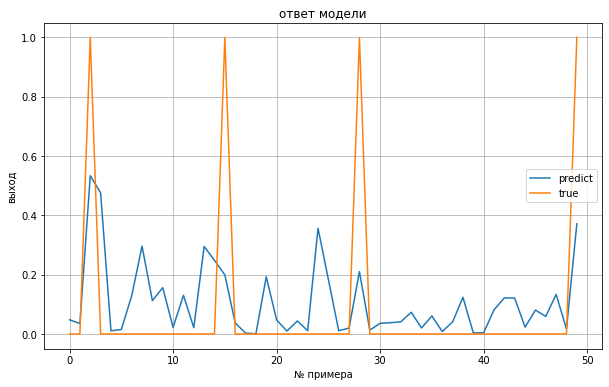

In [48]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Precision=0.681, Recall=0.792
Best Threshold=0.2965896893751641, F-Score=0.732, Precision=0.681, Recall=0.792


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1664   91]
 [  52  193]]


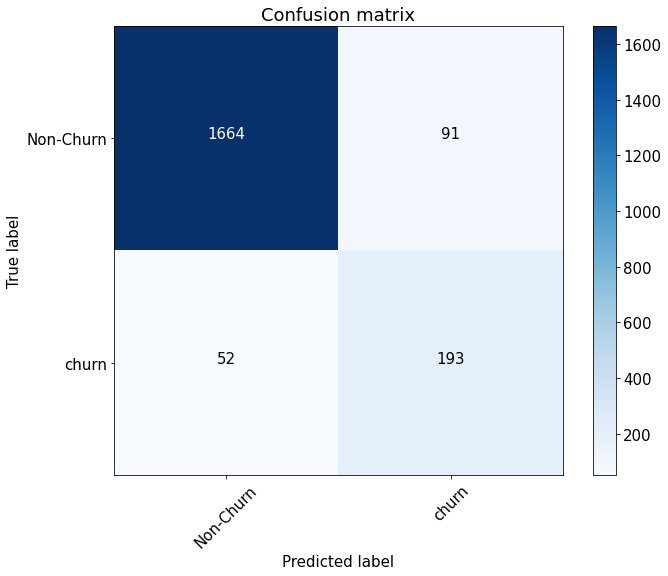

In [51]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [52]:
roc_auc_score(y_test, preds)

0.9697959183673469